# Graph Neural Network

Dieses Notebook ist ein erster Test des GNN Ansatzes für die Vorhersage von $\mu$ und $\sigma$

In [1]:
# Set Notebook Name for WandB
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'gnn.ipynb'
import sys
sys.path.append('../utils')

In [74]:
from helpers import load_data, load_stations, clean_data, normalize_data, create_data, visualize_graph, visualize_attention, compute_dist_matrix, visualize_explanation

from typing import Tuple, Optional
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCN, GCNConv, GATConv, GATv2Conv, Sequential, summary, MLP, GraphSAGE, ResGatedGraphConv, GINConv, GINEConv, BatchNorm, GAT
from torch_geometric.nn.pool import global_mean_pool
from torch.nn import Linear, Embedding, ModuleList
from torch.optim.lr_scheduler import MultiStepLR, StepLR, OneCycleLR
from tqdm import tqdm, trange

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopy.distance
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch_geometric
import torch.nn.functional as F
import wandb

%matplotlib inline
plt.style.use('default')

## Import of Data

In [3]:
# Get Data from feather
print("Loading Data ...")
data = load_data(indexed=False)

if not os.path.exists("dist_matrix.npy"):
    print("Creating distance matrix ...")
    stations = load_stations(data)  # This needs to be done here because we need all stations
    dist_matrix = compute_dist_matrix(stations)
    np.save(dist_matrix, 'dist_matrix.npy')

# Clean Data
print("Cleaning Data ...")
data = clean_data(data, max_missing=121, max_alt=1000.0)
# Normalize Data
print("Normalizing Data ...")
normalized_data = normalize_data(data, last_obs=-1460, method="max") #last_obs is -365 since the last year is used for testing

# Get List of stations with all stations -> will break further code if cut already
print("Extracting Stations ...")
stations = load_stations(data)

Loading Data ...
Cleaning Data ...
Normalizing Data ...
Extracting Stations ...


## Create the torch dataset

The Dataset which is a `pandas.DataFrame` gets converted to a `torch_geometric.data` object, which then can be processed by the GNN

In [4]:
# TODO set the maximum distance (might want to get this from a configuration file)
max_dist = 50
nearest_k = 5
dist_matrix = np.load('dist_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])


torch_data = []
for date in tqdm(data['date'].unique(), desc="Creating PyG Data"):
    torch_data.append(create_data(df=normalized_data,
                                  date=date,
                                  dist_matrix=dist_matrix,
                                  position_matrix=position_matrix,
                                  method='max_dist',
                                  max_dist=max_dist,
                                  k=nearest_k,
                                  nearest_k_mode="in"))

Creating PyG Data: 100%|██████████| 3530/3530 [00:25<00:00, 137.08it/s]


## Dataloaders

In [5]:
print(len(torch_data))

3530


In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda', index=1)

In [23]:
# TODO another hyperparameter here
BS = 8

# Move all the data directly to the GPU (should fit into memory)
torch_data = [tensor.to(device) for tensor in torch_data]

# Definition of train_loader and valid_loader
train_loader_small = DataLoader(torch_data[:365], batch_size=BS, shuffle=True)
train_loader_full = DataLoader(torch_data[:-365], batch_size=BS, shuffle=True)
train_loader = DataLoader(torch_data[:-1460], batch_size=BS, shuffle=True)
valid_loader = DataLoader(torch_data[-1460:-365], batch_size=BS, shuffle=True)

## Visualizations of Graph to test if everything worked fine

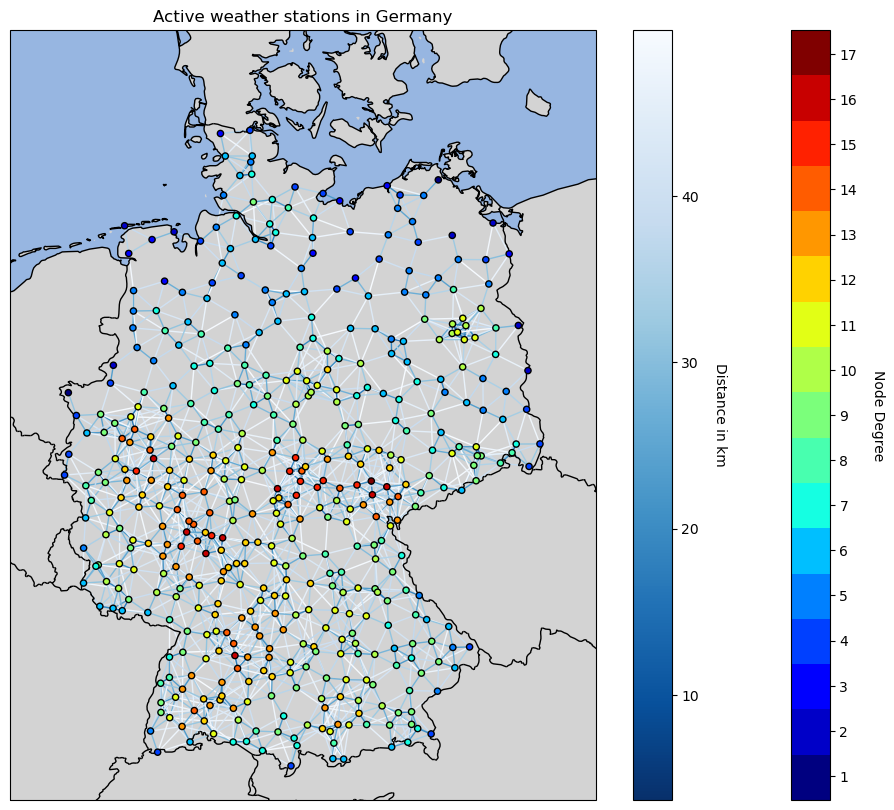

In [154]:
visualize_graph(torch_data[-1].cpu())

## GNN

In the following section the gnn is constructed. This is largely based on the [PyG Colab Notebooks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing).

#### ⚠️ TODO
 - Modularize -> use multiple torch.modules in a Sequential model
 - Early stopping should save model checkpoint
 - gin config
 - [Neural Tangent Kernel](https://en.wikipedia.org/wiki/Neural_tangent_kernel)
 - Attention weights mitteln und anschauen (Kanten in Graph einfärben)
 - W&B hinzufügen
 - Check out GNN explainer
 - Hyperparameter Optimization
 - Test different Layers and Architectures
    - Embed Node ID (wie in paper von Sebastian)
    - ResNet (Recidual Layer)
    - Softplus for sigma
    - Edge Weights
    - Try Out New Layer Types

### CRPS Loss Function

\begin{align*}

    \operatorname{crps}(F,X)=&\int_{-\infty}^{\infty}\left(F(y)-\boldsymbol{1}_{(y-x)}\right)^2dy\\

\end{align*}

Closed form expression from Gneiting et al. (2005)

\begin{align*}

    \operatorname{crps}\left(\mathcal{N}\left(\mu, \sigma^2\right), y\right)= & \sigma\left\{\frac{y-\mu}{\sigma}\left[2 \Phi\left(\frac{y-\mu}{\sigma}\right)-1\right] +2 \varphi\left(\frac{y-\mu}{\sigma}\right)-\frac{1}{\sqrt{\pi}}\right\}

\end{align*}

$\Phi\left(\frac{y-\mu}{\sigma}\right)$ denotes the CDF of a standard normal distribution and $\varphi\left(\frac{y-\mu}{\sigma}\right)$ denotes the PDF of a standard normal distribution

In [7]:
def crps(mu_sigma: torch.tensor, y: torch.tensor) -> torch.tensor:
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed df

    :param torch.tensor mu_sigma: tensor of mean and standard deviation
    :param torch.tensor y: observed df

    :return tensor: CRPS value
    :rtype torch.tensor
    """
    mu, sigma = torch.split(mu_sigma, 1, dim=-1)
    y = y.view((-1,1)) # make sure y has the right shape
    pi = np.pi #3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * pi))) * torch.exp(-0.5 * omega ** 2)
    
    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))
    
    crps_score = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(pi)))
    return  torch.mean(crps_score)

### GNN
Definition of Model and Training

In [14]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda', index=1)

### Definition of Convolution Layers

In [8]:
class Convolution(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, heads, num_layers:int=None):
        super(Convolution, self).__init__()
        # Make sure either hidden_channels is a list, heads is a list or num_layer is supplied
        assert isinstance(hidden_channels, list) or isinstance(heads, list) or num_layers is not None,\
                "If hidden_channels is not a list, num_layers must be specified."
        # both are a list
        if isinstance(hidden_channels, list) and isinstance(heads, list):
            assert len(hidden_channels) == len(heads), f"Lengths of lists {len(hidden_channels)} and {len(heads)} do not match."
        # only hidden_channels is list
        if isinstance(hidden_channels, list) and not isinstance(heads, list):
            heads = [heads] * len(hidden_channels)
        # only heads is list
        if isinstance(heads, list) and not isinstance(hidden_channels, list):
            hidden_channels = [hidden_channels] * len(heads)
        # none is list
        if not isinstance(heads, list) and not isinstance(hidden_channels, list):
            heads = [heads] * num_layers
            hidden_channels = [hidden_channels] * num_layers
        # definition of Layers
        self.convolutions = ModuleList()
        for c, h in zip(hidden_channels, heads):
            self.convolutions.append(GATv2Conv(in_channels=-1, out_channels=c, heads=h))
        # Last Layer to match shape of output
        self.lin = Linear(in_features=hidden_channels[-1] * heads[-1], out_features=out_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.tensor:
        for conv in self.convolutions:
            x = F.relu(conv(x, edge_index, edge_attr))
        x = self.lin(x)
        return x


class EmbedStations(torch.nn.Module):
    def __init__(self, num_stations_max, embedding_dim):
        super(EmbedStations, self).__init__()
        self.embed = Embedding(num_embeddings=num_stations_max, embedding_dim=embedding_dim)

    def forward(self, x: torch.Tensor):
        station_ids = x[:, 0].long()
        emb_station = self.embed(station_ids)
        x = torch.cat((emb_station, x[:, 1:]), dim=1) # Concatenate embedded station_id to rest of the feature vector
        return x


class MakePositive(torch.nn.Module):
    def __init__(self):
        super(MakePositive, self).__init__()

    def forward(self, x: torch.Tensor) -> torch.tensor:
        mu, sigma = torch.split(x, 1, dim=1)
        sigma = F.softplus(sigma)  # ensure that sigma is positive
        mu_sigma = torch.cat([mu, sigma], dim=1)
        return mu_sigma

class UseGlobalContext(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(UseGlobalContext, self).__init__()
        self.aggr = global_mean_pool
        self.lin = Linear(2 * in_features, out_features)

    def forward(self, x:torch.Tensor, batch_id:torch.Tensor) -> torch.tensor:
        global_features = self.aggr(x, batch_id)
        global_features_per_node = global_features[batch_id]
        input_vec = torch.cat([x, global_features_per_node], dim=-1)
        return self.lin(input_vec)

    
class ResGnn(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int, hidden_channels: int, heads: int):
        super(ResGnn, self).__init__()
        assert num_layers > 0, "num_layers must be > 0."

        # Create Layers
        self.convolutions = ModuleList()
        for _ in range(num_layers):
            self.convolutions.append(GATv2Conv(-1, hidden_channels, heads=heads, edge_dim=1))
        self.lin = Linear(hidden_channels * heads, out_channels) #hier direkt 2 testen
        self.norm = BatchNorm(hidden_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.tensor:
        x = x.float()
        edge_attr = edge_attr.float()
        for i, conv in enumerate(self.convolutions):
            if i == 0:
                # First Layer
                x = conv(x, edge_index, edge_attr)
                x = F.relu(x)
                x = self.norm(x)
            else:
                x = x + F.relu(conv(x, edge_index, edge_attr)) # Residual Layers

        x = self.lin(x)
        return x

    @torch.no_grad()
    def get_attention(self, x: torch.tensor, edge_index: torch.tensor, edge_attr: torch.tensor) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
        """
        Runs a forward Pass for the given graph only though the ResGNN layer.
        NOTE: the data that is given to this method must first pass through the layers before this layer in the Graph

        :param torch.tensor x: Tensor of Node Features (NxD)
        :param torch.tensor edge_index: Tensor of Edges (2xE)
        :param torch.tensor edge_attr: Edge Attributes (ExNum_Attr)
        :return x, edge_index_attention, attention_weights: Tensor of Node Features (NxD), Tensor of Edges with self loops (2xE), Tensor of Attention per edge (ExNum_Heads)
        """
        x = x.float()
        edge_attr = edge_attr.float()

        # Pass Data though Layer to get the Attention
        attention_list = []
        edge_index_attention, attention_weights = None, None  # Note: edge_index_attention has to be added since we have self loops now

        for i, conv in enumerate(self.convolutions,):
            if i == 0:
                # First Layer
                x, (edge_index_attention, attention_weights) = conv(x, edge_index, edge_attr, return_attention_weights=True)
                attention_list.append(attention_weights)
                x = F.relu(x)
                x = self.norm(x)
            else:
                x_conv, (edge_index_attention, attention_weights) = conv(x, edge_index, edge_attr, return_attention_weights=True)
                attention_list.append(attention_weights)
                x = x + F.relu(x_conv) # Residual Layers
        x = self.lin(x)

        # TODO Average the attention across all layers
        attention_weights = attention_weights.mean(dim=1)

        return x, edge_index_attention, attention_weights


### Graph Nets Message Passing Layer
The following Layer should be able to compute new node attributes from Messages shared across edges and also compute a global representation which is also used in the node attribute calculation.

$$ \mathbf{h}_i = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
\bigoplus_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
\left(\mathbf{x}_{i}, \mathbf{x}_{j},\mathbf{e}_{j,i}, \textcolor{green}{x_G}
\right), \textcolor{green}{x_G} \right)$$

$$\textcolor{green}{\mathbf{h}_G = \rho \left(\bigoplus_{i \in \mathcal{V}} \mathbf{h}_i,
\bigoplus_{(i,j) \in \mathcal{E}} \mathbf{h}_{i,j}, \mathbf{x}_G
\right)}$$

The user only has to define the functions $\phi_{\mathbf{\Theta}}$ , i.e. message(), and $\gamma_{\mathbf{\Theta}}$ , i.e. update(), as well as the aggregation scheme to use, i.e. aggr="add", aggr="mean" or aggr="max".
[Source](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html#implementing-the-gcn-layer)

The $\textcolor{green}{\text{green}}$ symbols are additions to the formulas from PyG, based on this [Lecture](https://www.dropbox.com/s/itsbi113f7ogpbv/AIMS%202022%20-%20Lecture%206%20-%20Graphs%20%26%20Sets%20II.pdf?dl=0).

![](plots/lecture.png)


In [9]:
class MPWGI(MessagePassing):
    """
    Message Passing with Global Information
    """
    def __init__(self, in_channels, edge_channels, global_channels, hidden_channels, out_channels):
        super().__init__(aggr='mean')
        self.psi = Linear(2 * in_channels + edge_channels + global_channels, hidden_channels)
        self.phi = Linear(in_channels + hidden_channels + global_channels, out_channels)
        self.rho = Linear(global_channels + out_channels, out_channels)
        self.pool = global_mean_pool

    def reset_parameters(self)  -> None:
        """
        Reset all parameters
        :return: None
        """
        self.psi.reset_parameters()
        self.phi.reset_parameters()
        self.rho.reset_parameters()

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor, edge_attr: torch.Tensor, global_features_i: torch.Tensor) -> torch.Tensor:
        """
        Corresponds to psi.
        Constructs a message from node j to node i for each edge in edge_index.
        Tensors passed to propagate() can be mapped to the respective nodes i and j and by appending _i or _j
        :param x_i: features of node i
        :param x_j: features of node j
        :param edge_attr: feature form node i to node j
        :param global_features: global feature of the entire graph
        :return: message passed from node j to node i
        """
        #global_features = global_features.repeat(x_i.shape[0], 1)
        message_input = torch.cat([x_i, x_j, edge_attr, global_features_i], dim=-1)
        message_transformed = self.psi(message_input)
        return message_transformed


    def update(self, inputs: torch.Tensor, x: torch.Tensor, global_features: torch.Tensor) -> torch.Tensor:
        """
        Corresponds to phi.
        Updates node embeddings.
        Takes in the output of aggregation as first argument and any argument which was initially passed to propagate().
        :param inputs: output of aggregation
        :param x_i: features of node i
        :param global_features: global feature of the entire graph
        :return: updated feature of node i
        """
        update_input = torch.cat([inputs, x, global_features], dim=-1)
        return self.phi(update_input)

    def forward(self, x, edge_index, edge_attr, global_features, batch_id):
        # Add self-loops to the adjacency matrix.
        #edge_index, edge_attr = add_self_loops(edge_index, edge_attr=torch.Tensor([0]))

        # Every node should have a global feature which is the same for every node in each batch
        # The batch number is stores in batch_id
        global_features_per_node = global_features[batch_id]

        # Propagate Messages
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr, global_features=global_features_per_node)

        # Update global feature
        # Corresponds to rho but only takes all nodes into consideration and omits messages
        aggregated_nodes = self.pool(x, batch=batch_id)
        global_input = torch.cat([global_features, aggregated_nodes], dim=-1)
        global_features = self.rho(global_input)

        return x, global_features

In [10]:
class GNNGI(torch.nn.Module):
    """
    Graph Neural Network with global Information
    """
    def __init__(self, in_channels, edge_channels, global_channels, hidden_channels, out_channels, num_layers, embedding_dim):
        """
        Create an instance of a Graph Neural Network with global Information sharing
        :param in_channels: dimension of node attributes before embedding
        :param edge_channels: dimension of edge attributes
        :param global_channels: dimension of global information vector, should be the same as in_channels+edge_channels
        :param hidden_channels: dimension of the message passed along the edges
        :param out_channels: describes the dimension of the new node features
        :param num_layers: number of layers
        :param embedding_dim: dimension to use of node embedding
        """
        super(GNNGI, self).__init__()
        self.convolutions = ModuleList()
        assert num_layers > 0, "num_layers must be greater than 0"
        for _ in range(num_layers-1):
            self.convolutions.append(MPWGI(in_channels, edge_channels, global_channels, hidden_channels, out_channels))
            in_channels = out_channels
        self.convolutions.append(MPWGI(in_channels, edge_channels, global_channels, hidden_channels, out_channels))  # Last Layer

        self.emb = EmbedStations(num_stations_max=535, embedding_dim=embedding_dim)
        self.pool = global_mean_pool
        self.lin = Linear(out_channels,2)
        self.make_pos = MakePositive()

    def forward(self, x, edge_index, edge_attr, batch_id, global_features=None):
        x = self.emb(x)

        if global_features is None:
            global_features = self.pool(x, batch=batch_id)  # Do batch-wise pooling

        x, global_feature = self.convolutions[0](x, edge_index, edge_attr, global_features, batch_id)
        x = F.relu(x)
        global_feature = F.relu(global_feature)

        if len(self.convolutions) > 1:
            for conv in self.convolutions[1:]:
                x_new, global_features_new = conv(x, edge_index, edge_attr, global_features, batch_id)
                x = x + F.relu(x_new)  # Resnet
                global_feature = global_feature + F.relu(global_features_new)  #Resnet

        x = self.lin(x)

        mu_sigma = self.make_pos(x)
        return mu_sigma

### Construction of Network

In [75]:
# TODO another parameter
LR = 0.002
EMBED_DIM = 10
hidden_channels = 128
heads = 1
num_layers = 4

# Initialize the model and optimizer
num_features = torch_data[0].num_features
emb_num_features = num_features + EMBED_DIM -1

def create_model(EMBED_DIM, in_channels, hidden_channels, num_layers, LR, schedule_lr: bool=False, compile: bool=False)\
        -> Tuple[torch.nn.Module, torch.optim.Optimizer, Optional[torch.optim.lr_scheduler.LRScheduler]]:
    """
    Create a graph neural network model for node level regression.

    :param EMBED_DIM: The dimensionality of the node embeddings.
    :param in_channels: The number of input features for the node embeddings.
    :param hidden_channels: The number of hidden channels in the Convolution layers.
    :param num_layers: The number Convolution layers in the model.
    :param LR: The max learning rate for the optimizer.
    :param schedule_lr: Whether to use a learning rate scheduler. Defaults to False.
    :param compile: Whether to compile the model with torch_geometric. Defaults to False.

    :return: A tuple containing the created model, the optimizer, and an optional learning rate scheduler if schedule_lr is True.
    :rtype: Tuple[torch.nn.Module, torch.optim.Optimizer, Optional[torch.optim.lr_scheduler._LRScheduler]]
    """
    # Clear Cache
    #torch.cuda.empty_cache()
    #model = GNNOld(num_features=num_features, hidden_channels=16, heads=8)
    mod = Sequential('x, edge_index, edge_attr, batch_id',
                       [
                           (EmbedStations(num_stations_max=535, embedding_dim=EMBED_DIM ), 'x -> x'),

                           #(ResGnn(in_channels=-1, out_channels=2, hidden_channels=hidden_channels, heads=heads, num_layers=num_layers), 'x, edge_index, edge_attr -> x'),

                           #(GAT(in_channels=-1, out_channels=2, hidden_channels=hidden_channels, num_layers=num_layers, jk='lstm',  v2=True, heads=heads, edge_dim=1), 'x, edge_index -> x'),

                           #(Convolution(in_channels=-1, out_channels=2, hidden_channels=hidden_channels, heads=heads, num_layers=num_layers), 'x, edge_index, edge_attr -> x'),

                           #(lambda edge_attr: edge_attr.flatten(), 'edge_attr -> edge_weight'),

                           (GraphSAGE(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers, out_channels=2), 'x, edge_index -> x'),

                           #(ResGatedGraphConv(in_channels=-1, out_channels=2), 'x, edge_index -> x'),

                           # (GINEConv(nn=torch.nn.Sequential(
                           #        torch.nn.Linear(emb_num_features, 512),
                           #        torch.nn.ReLU(),
                           #        torch.nn.Linear(512, 512),
                           #        torch.nn.ReLU(),
                           #        torch.nn.Linear(512, 2)),
                           #    edge_dim=1), 'x, edge_index, edge_attr -> x'),

                           #(MLP(in_channels=emb_num_features, out_channels=2, hidden_channels=512, num_layers=2),'x -> x'),

                           # TODO new idea: add global_layer at end to allow for long range dependencies:
                           # Something like this
                           #global_x = self.linear(global_mean_pool(x, batch))
                           #x = x + global_x[batch]

                           (MakePositive(), 'x -> mu_sigma')
                       ])
    # model = GNNGI(in_channels=in_channels,
    #               edge_channels=1,
    #               global_channels=in_channels,
    #               hidden_channels=hidden_channels,
    #               out_channels=in_channels,
    #               num_layers=num_layers,
    #               embedding_dim=EMBED_DIM)

    model.to(device)
    if compile: torch_geometric.compile(model)
    opt = torch.optim.AdamW(model.parameters(), lr=LR) #momentum anschauen
    # Learning Rate Scheduler
    sched = None
    if schedule_lr:
        s = OneCycleLR(optimizer, max_lr=LR, epochs=80, steps_per_epoch=len(train_loader_full))#MultiStepLR(optimizer, milestones=[60, 90, 100, 110], gamma=0.1)
    return  mod, opt, sched

### Finding the Optimal learning rate
This code is based on [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf) by Leslie N. Smith and also inspired by this [Project](https://github.com/davidtvs/pytorch-lr-finder).

100%|██████████| 100/100 [04:11<00:00,  2.52s/it]


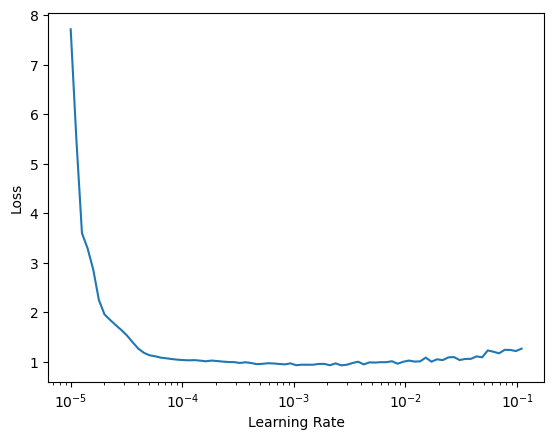

Optimal learning rate: 0.0026560877449810505


In [57]:
model, optimizer, _ = create_model(EMBED_DIM=EMBED_DIM,
                                   in_channels=emb_num_features,
                                   hidden_channels=hidden_channels,
                                   num_layers=num_layers,
                                   LR=LR,
                                   compile=True)

# Define learning rate range
lr_start = 0.00001
lr_end = 1
lr_values_tensor = torch.logspace(torch.log10(torch.tensor(lr_start)), torch.log10(torch.tensor(lr_end)), steps=100)

# Set up containers to store losses and learning rates
lr_values = []
losses = []

# Iterate over learning rates
for lr in tqdm(lr_values_tensor):
    # Set the learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = float(lr)

    # Train for one epoch
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch.x, batch.edge_index, batch.edge_attr, batch_id=batch.batch)
        loss = crps(output, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate average loss and store results
    avg_loss = total_loss / len(train_loader)
    lr_values.append(lr.item())
    losses.append(avg_loss)

# Plot the learning rate vs. the loss
import matplotlib.pyplot as plt

plt.plot(lr_values, losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.show()

# Get the optimal learning rate
optimal_lr = lr_values[losses.index(min(losses))]
print("Optimal learning rate:", optimal_lr)


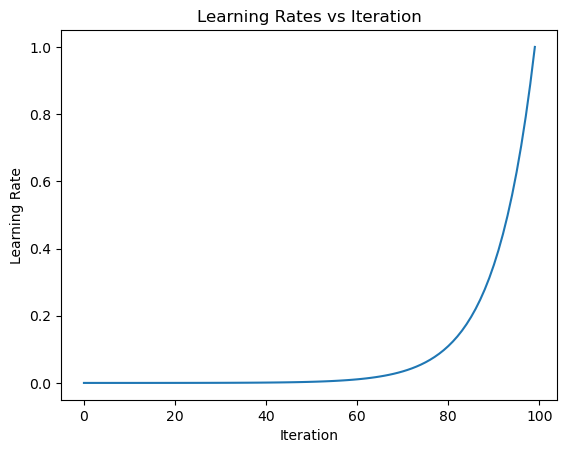

In [73]:
plt.plot(lr_values)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rates vs Iteration')
plt.show()

In [ ]:
LR = optimal_lr

### Training
An ensemble of 10 models is trained for 80 periods or until the validation loss has not decreased in 30 epochs per model.

In [61]:
log_WandB = False

In [66]:
#TODO more hyperparams here
n_epochs = 80
patience = 30
n_reps = 1


if log_WandB:
    wandb.init(
    # set the wandb project where this run will be logged
        project="GNNPP",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": LR,
        "architecture": "ResNetv2",
        "embed_dim": EMBED_DIM,
        "num_layers": num_layers,
        "hidden_channels": hidden_channels,
        "heads": heads,
        "max_epochs": n_epochs,
        "patience": patience,
        "batch_size": BS,
        "max_dist": max_dist
        }
    )


def train(batch):
    #batch.to(device)
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.edge_attr, batch_id=batch.batch)
    loss = crps(out, batch.y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss

@torch.no_grad()
def valid(batch):
    #batch.to(device)
    out = model(batch.x, batch.edge_index, batch.edge_attr, batch_id=batch.batch)
    loss = crps(out, batch.y)
    return loss

model_list = []
train_losses_models = []
validation_losses_models = []

for i in range(n_reps):
    train_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    no_improvement = 0

    # loading bar
    epochs_pbar = trange(n_epochs, desc="Epochs")
    model, optimizer, scheduler = create_model(EMBED_DIM=EMBED_DIM,
                                               in_channels=emb_num_features,
                                               hidden_channels=hidden_channels,
                                               num_layers=num_layers,
                                               LR=LR,
                                               schedule_lr=True)

    for epoch in epochs_pbar:
        # Train for one epoch
        model.train()
        train_loss = 0.0

        for batch in train_loader_full:
            loss = train(batch)
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluate on the validation set
        model.eval()
        val_loss = 0.0

        for batch in valid_loader:
            loss = valid(batch)
            val_loss += loss.item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)
        validation_losses.append(val_loss)

        # Log to WandB
        if log_WandB:
            wandb.log({"train_loss": train_loss, "val_loss": val_loss})

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            # Save model checkpoint
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"checkpoints/checkpoint_model_{i}.pt")
        else:
            no_improvement += 1

        epochs_pbar.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss,"Best Loss": best_val_loss, "No Improvement": no_improvement, "Learning Rate": scheduler.get_last_lr()})
        # Early stopping
        if no_improvement == patience:
            print('Early stopping.')
            break

    if log_WandB:
        wandb.log({"best_val_loss": best_val_loss, "trained_epochs":  epoch-patience})

    # Load weights from model checkpoint
    checkpoint = torch.load(f"checkpoints/checkpoint_model_{i}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Set model to eval mode
    model.eval()
    model_list.append(model)
    train_losses_models.append(train_losses)
    validation_losses_models.append(validation_losses)

Epochs: 100%|██████████| 80/80 [05:37<00:00,  4.22s/it, Train Loss=1.13, Val Loss=0.72, Best Loss=0.72, No Improvement=1, Learning Rate=[1.0813546757485181e-08]]  


In [16]:
# Load model from memory
# Only needed if there is a crash but some models are already trained
if False:
    model, optimizer, scheduler = create_model(EMBED_DIM=EMBED_DIM, emb_num_features=emb_num_features, hidden_channels=hidden_channels, num_layers=num_layers, LR=LR)

    checkpoint = torch.load(f"checkpoints/checkpoint_model_0.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    model_list = [model]

In [67]:
# Summary of model
tmp = torch_data[1000]

print(summary(model_list[0],
              x=tmp.x.to(device),
              edge_index=tmp.edge_index.to(device),
              edge_attr=tmp.edge_attr.to(device),
              batch_id=torch.zeros(tmp.x.shape[0]).to(torch.int64).to(device)))

+----------------------------------------+-----------------------+----------------+----------+
| Layer                                  | Input Shape           | Output Shape   | #Param   |
|----------------------------------------+-----------------------+----------------+----------|
| Sequential_f9f73d                      |                       | [472, 2]       | 84,840   |
| ├─(module_0)EmbedStations              | [472, 42]             | [472, 51]      | 5,350    |
| │    └─(embed)Embedding                | [472]                 | [472, 10]      | 5,350    |
| ├─(module_1)GraphSAGE                  | [472, 51], [2, 4338]  | [472, 2]       | 79,490   |
| │    └─(act)ReLU                       | [472, 128]            | [472, 128]     | --       |
| │    └─(convs)ModuleList               | --                    | --             | 79,490   |
| │    │    └─(0)SAGEConvJittable_fa02f4 | [472, 51], [2, 4338]  | [472, 128]     | 13,184   |
| │    │    └─(1)SAGEConvJittable_fa0f3e | [472, 1

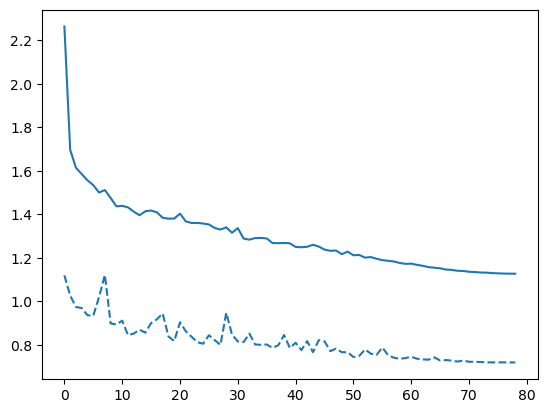

In [68]:
cmap = mpl.colormaps['tab10']
for i, (t, v) in enumerate(zip(train_losses_models, validation_losses_models)):
    plt.plot(t[1:], linestyle='solid', color=cmap(i))
    plt.plot(v[1:], linestyle='dashed',  color=cmap(i))
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Evaluation
Calculation of CRPS on test set and graphical diagnostics

In [69]:
test_loader = DataLoader(torch_data[-365:], batch_size=BS, shuffle=False)

In [70]:
mu_list_model = []
sigma_list_model = []

for model in model_list:
    mu_list_batch = []
    sigma_list_batch = []
    y_list = []

    for batch in test_loader:
        batch.to(device)
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        mu, sigma = torch.split(out, 1, dim=-1)
        y = batch.y
        y = y.cpu().numpy()
        y_list.append(y)

        mu = mu.detach().cpu().numpy().flatten()
        mu_list_batch.append(mu)
        sigma = sigma.detach().cpu().numpy().flatten()
        sigma_list_batch.append(sigma)


    mu = np.concatenate(mu_list_batch)
    mu_list_model.append(mu)
    sigma = np.concatenate(sigma_list_batch)
    sigma_list_model.append(sigma)
    y = np.concatenate(y_list)
mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)

mu = torch.tensor(mu).to(device)
sigma = torch.tensor(sigma).to(device)
preds = torch.cat([mu, sigma], dim=1)
y = torch.tensor(y).to(device)
err = crps(mu_sigma=preds, y=y)

y = y.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
sigma = sigma.detach().cpu().numpy()

Text(0.5, 1.0, 'Predicted vs. observed temperatures\nCRPS=0.7621')

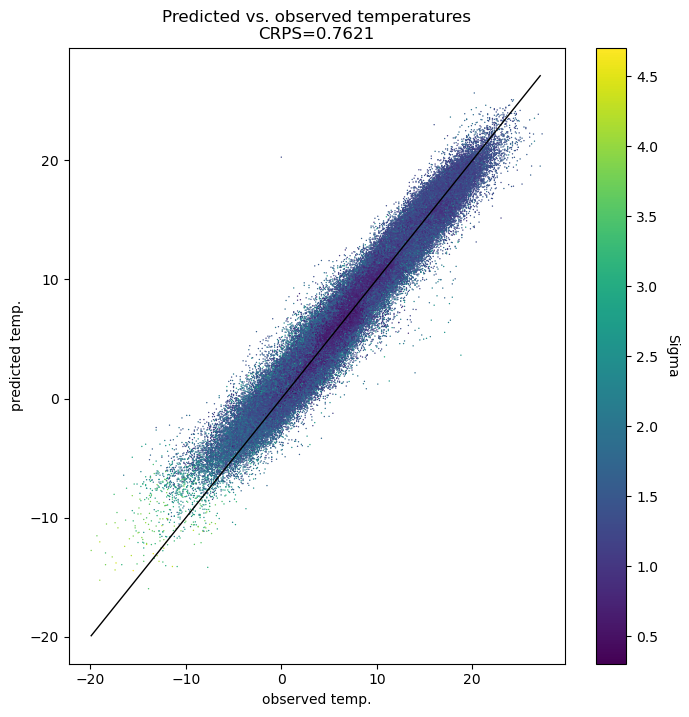

In [71]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis")

cbar = plt.colorbar()
cbar.set_label('Sigma', rotation=270, labelpad=15)
plt.xlabel('observed temp.')
plt.ylabel('predicted temp.')
plt.title(f"Predicted vs. observed temperatures\nCRPS={err:.4f}")

In [21]:
if log_WandB:
    # save code
    wandb.save("gnn.ipynb")
    wandb.save("helpers.py")
    # finish logging
    wandb.finish()

## Explainability

In [164]:
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import GNNExplainer

In [165]:
tmp = torch_data[-1]
node_index = [0]

explainer = Explainer(model=model_list[0],
                algorithm=GNNExplainer(),
                explanation_type='model',
                node_mask_type='attributes',
                edge_mask_type='object',
                model_config=ModelConfig(
                    mode='regression',
                    task_level='node',
                    return_type='raw')
                )

In [166]:
explanation = explainer(tmp.x.to(device),
                        tmp.edge_index.to(device),
                        edge_attr=tmp.edge_attr.to(device),
                        batch_id=torch.zeros(tmp.x.shape[0], dtype=torch.int64 ,device=device),
                        index=node_index)

exp_subgraph = explanation.get_explanation_subgraph()

ValueError: Explainability of message passing modules is only supported on the Python module

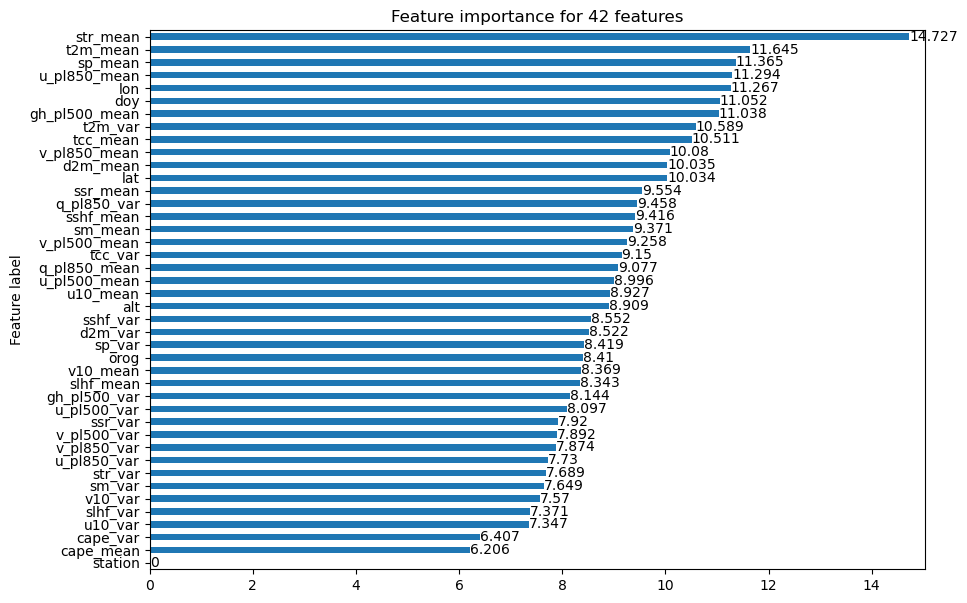

In [148]:
explanation.visualize_feature_importance(feat_labels=data.columns.drop(['date', 'obs']))

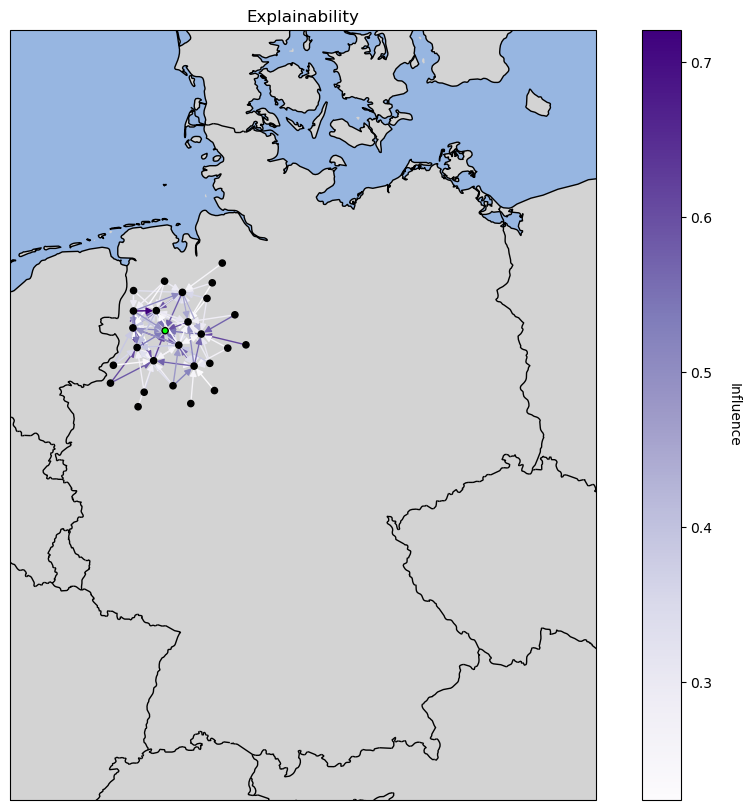

In [149]:
visualize_explanation(exp_subgraph.cpu(), tmp.cpu(), stations=stations)